In [113]:
import os
import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt

from diffEq import odes, plot

## Test differential equation:

$\frac{dT(t)}{dt} = r(T_{env} - T(t))$



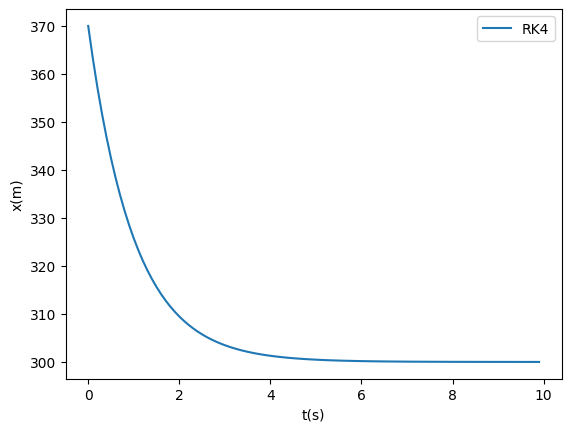

In [114]:
r = 1
T_env = 300

# args = [T]
def DT(t, args):
    return r*(T_env - args[0])

cooling_obj = odes([DT], [370])

t_list, T_list = cooling_obj.solve_Runge_Kutta(0, 10, h=0.1, stage=4)
solutions = {"RK4": (t_list, T_list)}

plot(solutions)

## Getting device for training

In [144]:
if torch.accelerator.is_available():
    device = torch.accelerator.current_accelerator().type
    print(device)

## Preparing data

Here we create synthetic data to test the model architecture. In real life (in a real experiment) we get our data and then apply our model to it. But now since we want to build a model, we create synthetic data to train it (and test it). So in real life of course we don't know T(t) exactly since this is what we want to calculate with our ML model.

In [153]:
n_step = 200 #number of time points when simulating T(t)
n_exp = 500 #number of experiment to train model on
n_train = 400

#For each of the 100 experiments we now have a unique (r, T_env, T_0) triplet
torch.manual_seed(0) #get the same random numbers everytime you run the code
r_tensor = torch.rand(n_exp, 1) #random cooling rate between 0 and 1 (100 times)
T_env_tensor = torch.rand(n_exp, 1) * 500 #random ambient temperature between 0 and 500 (100 times)
T_0_tensor = T_env_tensor + torch.rand(n_exp, 1) * 100 #Initial temperature, slightly higher than the ambient temperature (between 0K and 100K hotter) (100 times)


t_tensor = torch.linspace(0, 50, n_step) #n_step (100) equally spaced time points between 0 and 50 seconds
T_tensor = T_env_tensor - (T_env_tensor - T_0_tensor)*torch.exp(-r_tensor * t_tensor) #creates 100 * 100 points, where each experiment has its own sampled datapoints (from exact solution)

# Split data into training and test sets
r_train, T_env_train, T_0_train, T_train = r_tensor[:n_train], T_env_tensor[:n_train], T_0_tensor[:n_train], T_tensor[:n_train]
X_train = torch.cat((r_train, T_env_train, T_0_train), 1) #C_train is a 90*3 tensor containing input features for training

#Standardize training inputs X_norm = X-µ/std, so each feature (column) has mean 0 and std1
X_train_mean = X_train.mean(dim=0, keepdim=True)
X_train_std = X_train.std(dim=0, keepdim=True)
X_train = (X_train - X_train_mean) / X_train_std

#Do the same for test data
r_test, T_env_test, T_0_test, T_test = r_tensor[n_train:], T_env_tensor[n_train:], T_0_tensor[n_train:], T_tensor[n_train:]
X_test = torch.cat((r_test, T_env_test, T_0_test), 1)

X_test_mean = X_test.mean(dim=0, keepdim=True)
X_test_std = X_test.std(dim=0, keepdim=True)
#X_test = (X_test - X_test_mean) / X_test_std       #test 1
X_test = (X_test - X_train_mean) / X_train_std


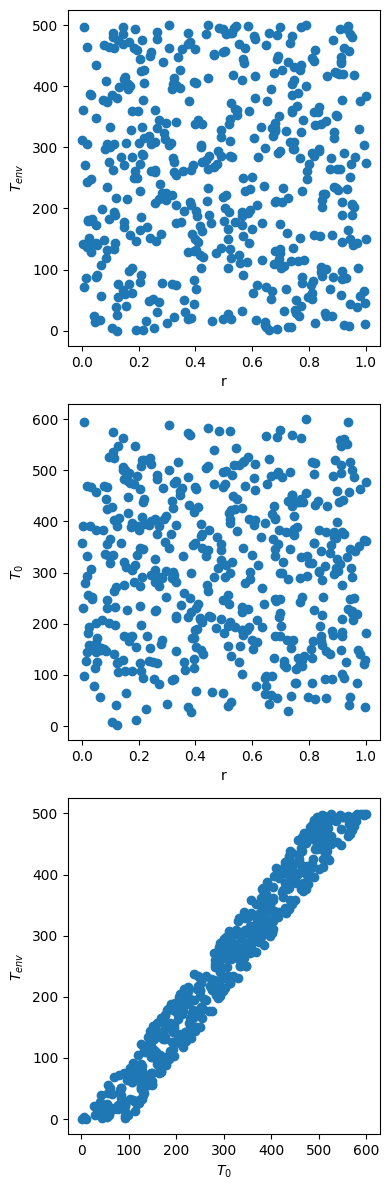

In [154]:
#Check if we cover the phase space evenly
fig, ax = plt.subplots(3,1, figsize = (4,12))

ax[0].scatter(r_tensor, T_env_tensor)
ax[0].set_xlabel("r")
ax[0].set_ylabel(r"$T_{env}$")

ax[1].scatter(r_tensor, T_0_tensor)
ax[1].set_xlabel("r")
ax[1].set_ylabel(r"$T_0$")

ax[2].scatter(T_0_tensor, T_env_tensor)
ax[2].set_xlabel(r"$T_0$")
ax[2].set_ylabel(r"$T_{env}$")

plt.tight_layout()
plt.show()

## Defining the model

In [155]:
class CoolingModel(nn.Module):
    def __init__(self, n_step):
        super().__init__()
        self.fc1 = nn.Linear(3, 32)    # Takes input vectors of size 3 (r, T_env, T_0) and outputs 32 hidden features
        self.fc2 = nn.Linear(32, n_step)  # Maps 32 hidden features to output of size n_size (predicted temperature curve over time)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))     # smooth activation
        x = self.fc2(x)
        return x

# Initiate the model
model = CoolingModel(n_step) #creates a model object using the class, with the chosen number of time steps

In [156]:
# Loss function and optimizer
loss_func = nn.MSELoss() #mean square error loss (measures average squared difference between predicted value and true targets) (what the ML model wants to minimize)

#optimizer = optim.SGD(model.parameters(), lr=0.01)
#optimizer = optim.Adam(model.parameters(), lr=0.001) #New optimizer

#optimizer = optim.Adam(which weights/biases to update, Learning rate — controls the step size for updates, L2 regularization - prevents weights from growing too large (better generalization))
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4) #updates model parameters based on the gradients computed from the loss

## Train the model

In [161]:
epochs = 30000 #One complete pass through entire training dataset (update weights 20000 times)

for epoch in range(epochs):
    T_pred = model(X_train) #forward pass
    
    loss = loss_func(T_pred, T_train) #compute loss

    optimizer.zero_grad() #reset gradients
    loss.backward() #compute gradients of the loss
    
    optimizer.step() #update parameters

    if (epoch+1) % 100 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

Epoch 100/30000, Loss: 20.0877
Epoch 200/30000, Loss: 19.9065
Epoch 300/30000, Loss: 19.7277
Epoch 400/30000, Loss: 19.5516
Epoch 500/30000, Loss: 19.3787
Epoch 600/30000, Loss: 19.2090
Epoch 700/30000, Loss: 19.0429
Epoch 800/30000, Loss: 18.8807
Epoch 900/30000, Loss: 18.7223
Epoch 1000/30000, Loss: 18.5679
Epoch 1100/30000, Loss: 18.4179
Epoch 1200/30000, Loss: 18.2716
Epoch 1300/30000, Loss: 18.1296
Epoch 1400/30000, Loss: 17.9916
Epoch 1500/30000, Loss: 17.8576
Epoch 1600/30000, Loss: 17.7274
Epoch 1700/30000, Loss: 17.6010
Epoch 1800/30000, Loss: 17.4781
Epoch 1900/30000, Loss: 17.3586
Epoch 2000/30000, Loss: 17.2424
Epoch 2100/30000, Loss: 17.1294
Epoch 2200/30000, Loss: 17.0193
Epoch 2300/30000, Loss: 16.9120
Epoch 2400/30000, Loss: 16.8072
Epoch 2500/30000, Loss: 16.7049
Epoch 2600/30000, Loss: 16.6050
Epoch 2700/30000, Loss: 16.5073
Epoch 2800/30000, Loss: 16.4115
Epoch 2900/30000, Loss: 16.3156
Epoch 3000/30000, Loss: 16.2166
Epoch 3100/30000, Loss: 16.1127
Epoch 3200/30000,

In [162]:
model.eval()
with torch.no_grad():
    T_pred_test = model(X_test)
    test_loss = loss_func(T_pred_test, T_test)
    print(f"Test Loss: {test_loss.item():.4f}")

Test Loss: 7.9088


In [163]:
for name, param in model.named_parameters():
    print(name, param.data)

fc1.weight tensor([[  0.0558, -17.0267,   1.4394],
        [  0.0204,  -0.5888,  -0.1910],
        [ -0.0204,   0.5888,   0.1910],
        [ -0.2546,  -2.1602,  -0.3600],
        [ -0.0595, -11.1052,   1.2889],
        [ -2.0274,  -3.9993,   4.2128],
        [  0.5050,   4.5938,  -1.7251],
        [ -0.2848,  -6.1360,   2.1383],
        [ -0.0204,   0.5888,   0.1910],
        [  0.0204,  -0.5888,  -0.1910],
        [  0.2306,  -3.9996,   4.8939],
        [  0.0204,  -0.5888,  -0.1910],
        [ -0.0698,   0.3973,  -1.6625],
        [ -0.0204,   0.5888,   0.1910],
        [  0.3604,   6.5243,  -3.0344],
        [  0.0204,  -0.5888,  -0.1910],
        [  0.0204,  -0.5888,  -0.1910],
        [  0.1160,   4.6676,  -1.7124],
        [  0.1173,   2.6729,  -3.1374],
        [  0.0204,  -0.5888,  -0.1910],
        [ -0.0204,   0.5888,   0.1910],
        [  0.0879,  -5.6159,   0.4476],
        [  0.2332,  -4.5881,   1.0181],
        [  0.3588,  -4.2572,   0.8067],
        [  0.3120,  -4.0804, 

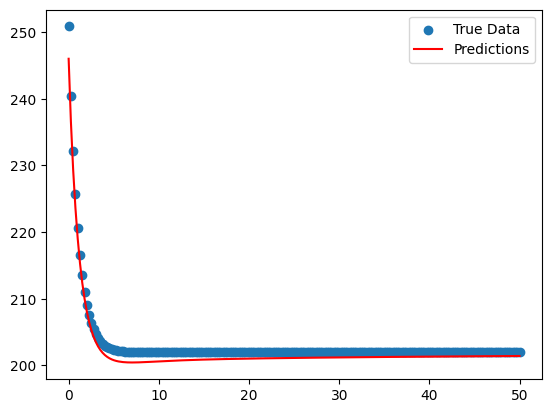

In [164]:
plt.scatter(t_tensor, T_test[-1], label="True Data")
plt.plot(t_tensor, T_pred_test[-1], color="red", label="Predictions")
plt.legend()
plt.show()